<a href="https://colab.research.google.com/github/inachenyx/CompressedSensing/blob/main/CompressedSensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx

## 1D Compressive Sensing

Text(0, 0.5, 'yt')

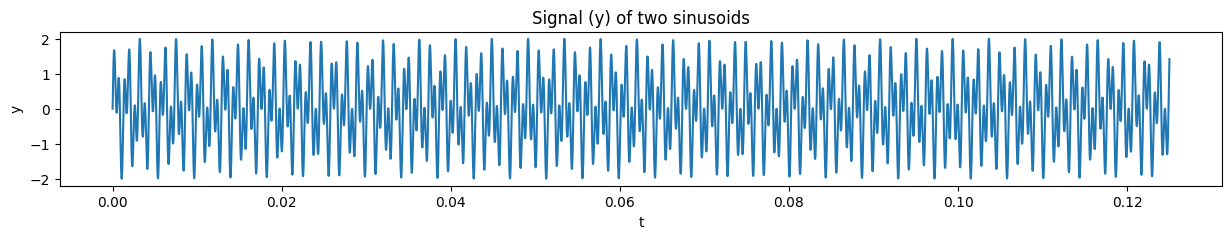

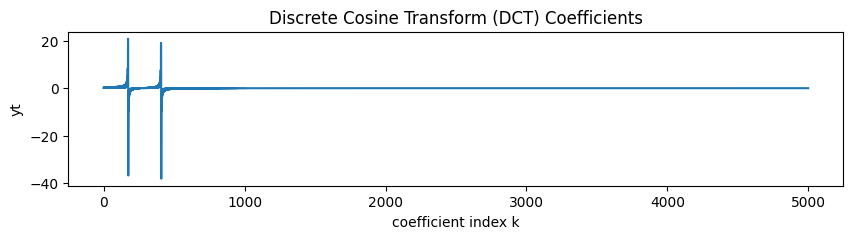

In [ ]:
# sum of two sinusoids
n = 5000
t = np.linspace(0, 1/8, n) # 5000 timesteps btw 0 and 0.125
y = np.sin(1394 * np.pi * t) + np.sin(3266 * np.pi * t) # sine waves of freq 697, 1633 Hz
yt = spfft.dct(y, norm='ortho')

plt.figure(figsize=(15, 2))
plt.plot(t, y)
plt.title('Signal (y) of two sinusoids')
plt.xlabel('t')
plt.ylabel('y')
plt.figure(figsize=(10, 2))
plt.plot(yt)
plt.title("Discrete Cosine Transform (DCT) Coefficients")
plt.xlabel('coefficient index k')
plt.ylabel('yt')

Text(0, 0.5, 'y_samp')

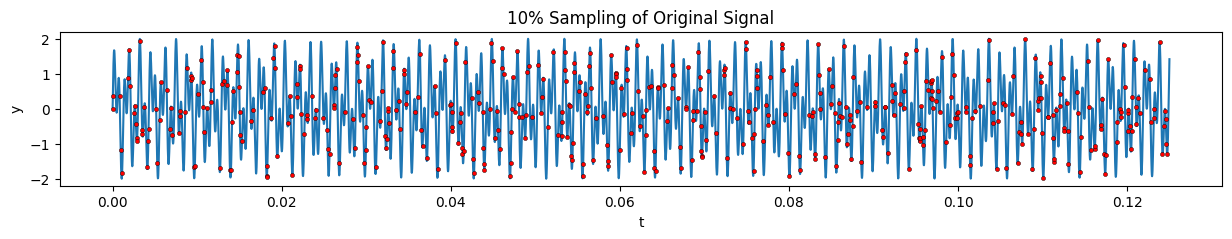

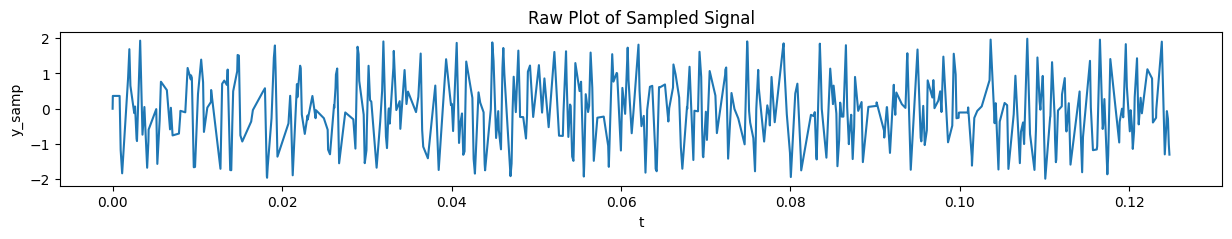

In [ ]:
# extract small sample of signal
m = 500 # 10% sample
ri = np.random.choice(n, m, replace=False) # random sample of indices
ri.sort() # sorting not strictly necessary, but convenient for plotting
t2 = t[ri]
y2 = y[ri]

plt.figure(figsize=(15, 2))
plt.plot(t, y)
plt.plot(t2, y2, 'o', markersize=3, markerfacecolor='red', markeredgecolor='black', markeredgewidth=0.3)
plt.title('10% Sampling of Original Signal')
plt.xlabel('t')
plt.ylabel('y')

plt.figure(figsize=(15, 2))
plt.plot(t2, y2)
plt.title('Raw Plot of Sampled Signal')
plt.xlabel('t')
plt.ylabel('y_samp')

In [ ]:
# Use the optimization library CVXPY to find signals that:
# (1) match up exactly with incomplete samples, (2) minimize the L1 norm of the frequencies

# create idct matrix operator
A = spfft.idct(np.identity(n), norm='ortho', axis=0) # A: the inverse DCT matrix
print(A.shape)
A = A[ri]
print(A.shape)

(5000, 5000)
(500, 5000)


In [ ]:
# do L1 optimization
vx = cvx.Variable(n) # the DCT coeff vector to solve for
print(vx.shape)
objective = cvx.Minimize(cvx.norm(vx, 1)) # minimize L1 norm - promote sparsity
constraints = [A*vx == y2] # exactly match known sampled values
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True) # the optimal value of the objective function (L1 norm)

(5000,)
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 20 06:25:05 AM: Your problem has 5000 variables, 500 constraints, and 0 parameters.
(CVXPY) May 20 06:25:05 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 20 06:25:05 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 20 06:25:05 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 20 06:25:05 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 20 06:25:05 AM: Compiling problem (target solver

/usr/local/lib/python3.11/dist-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) May 20 06:25:07 AM: Applying reduction CLARABEL
(CVXPY) May 20 06:25:08 AM: Finished problem compilation (took 3.272e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) May 20 06:25:08 AM: Invoking solver CLARABEL  to obtain a solution.
-------------------------------------------------------------
           Clarabel.rs v0.10.0  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 10000
  constraints   = 10500
  nnz(P)        = 0
  nnz(A)        = 2519779
  cones (total) = 2
    :        Zero = 1,  numel = 500
    : Nonnegative = 1,  numel = 10000

settings:
  linear algebra: dir

In [ ]:
# reconstruct signal
x = np.array(vx.value) # x: optimal DCT coefficients
x = np.squeeze(x) # clean up unnecessary dimensions
sig = spfft.idct(x, norm='ortho', axis=0) # inverse DCT (spectral > temporal domain)

plt.figure(figsize=(15, 2))
plt.plot(x)
plt.title("Optimal DCT Coefficients")
plt.xlabel('k')
plt.ylabel('x')
plt.figure(figsize=(15, 2))
plt.plot(t, sig)
plt.title("Reconstructed Signal")
plt.xlabel('t')
plt.ylabel('sig')
plt.figure(figsize=(15, 2))
plt.plot(t, y)
plt.title("Original Signal")
plt.xlabel('t')
plt.ylabel('y')

## Reconstruction of an image (2D Signal)

In [ ]:
import imageio.v3 as iio
from PIL import Image

In [ ]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

# read original image and downsize for speed
img = iio.imread('https://upload.wikimedia.org/wikipedia/en/e/e8/Escher_Waterfall.jpg')
Xorig = np.array(Image.fromarray(img).convert('L')) # 'L' for grayscale
X = spimg.zoom(Xorig, 0.18) # Downsample to 18% of the original size (interpolation-based resizing) due to memory limitations imposed by A matrix
ny,nx = X.shape
Xt = dct2(X) # Transform of downsampled image

print(f'X.shape=(ny,nx)={X.shape}')
plt.figure()
plt.imshow(Xorig, cmap='hot')
plt.title('Original Image')
plt.figure()
plt.imshow(X, cmap='hot')
plt.title('Downsized Image')
plt.figure()
plt.imshow(np.log1p(np.abs(Xt)), cmap='grey') # Apply a logarithmic scaling to reduce dynamic range
plt.title('Downsized Image (Transformed)')

(1600, 1)
[[ 40]
 [ 79]
 [145]
 ...
 [ 29]
 [ 55]
 [ 38]]
(64, 50)
[[False  True  True ...  True  True  True]
 [ True False False ...  True False False]
 [False False False ...  True False  True]
 ...
 [False False False ...  True  True  True]
 [ True False False ...  True  True  True]
 [False False False ...  True False  True]]


Text(0.5, 1.0, 'Masked Image (Sampled Pixels Only)')

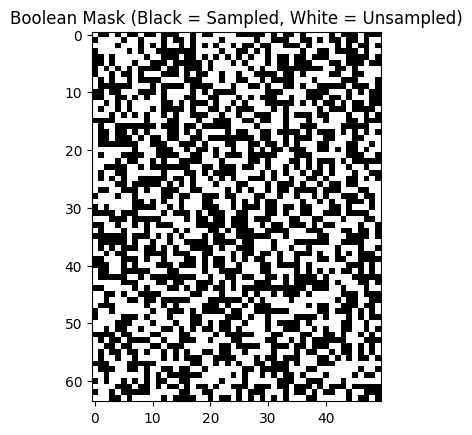

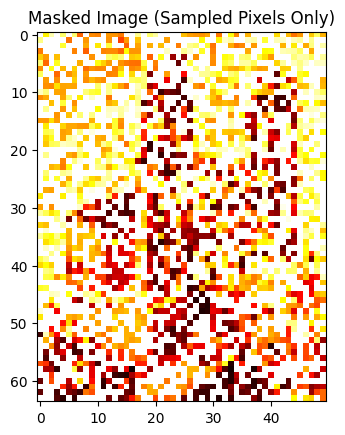

In [ ]:
# extract small sample of signal
k = round(nx * ny * 0.5) # 50% sample, k = 0.5*64*50 = 1600
ri = np.random.choice(nx * ny, k, replace=False) # ri: 1D array of shape (1600,) - 1600 unique random indices from the flattened array (values from 0 to 3199)
b = X.T.flat[ri] # (1600,) - samples from the original X in column-major order, the flattened layout is: X[0,0], X[1,0], ..., X[63,0], X[0,1], X[1,1], ..., X[63,49]
b = np.expand_dims(b, axis=1) # (1600,1) - expands to a column vector of 1,600 randomly sampled pixel values from X (in that flattened order)
print(b.shape)
print(b)

# Create boolean mask of sampled pixels
mask = np.zeros_like(X.T, dtype=bool).flatten()  # X.T was flattened when indexing
mask[ri] = True                                  # Mark the sampled indices
mask = mask.reshape(X.T.shape).T                 # Reshape and transpose back to match X shape
print(mask.shape)
print(mask)

# Create a binary image:
mask_img = ~mask  # Invert so sampled = 0 (black), unsampled = 1 (white)

plt.figure()
plt.imshow(mask_img, cmap='gray', vmin=0, vmax=1)
plt.title('Boolean Mask (Black = Sampled, White = Unsampled)')

# Create masked image
masked_image = np.full_like(X, fill_value=255)  # Start with all white
masked_image[mask] = X[mask]                   # Copy real pixel values at sampled locations

plt.figure()
plt.imshow(masked_image, cmap='hot', vmin=0, vmax=255)
plt.title('Masked Image (Sampled Pixels Only)')


## Compressive Sensing of Spike Activities